In [ ]:
import os
os.chdir("/home/guido/github/physioex-private/papers/icml")

import torch
import numpy as np
from torch import nn



from src.synt_data import SyntDataset
from src.model import TimeModule

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# print current directory
os.getcwd()


dataset = SyntDataset()

torch.Size([50000, 1000]) torch.Size([50000])


In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

signal, mask, target = dataset.__getitem__(7, return_mask=True)

# plot the signal
plt.plot(signal)
plt.show()
plt.close()

# plot the mask
plt.plot(mask)
plt.show()
plt.close()

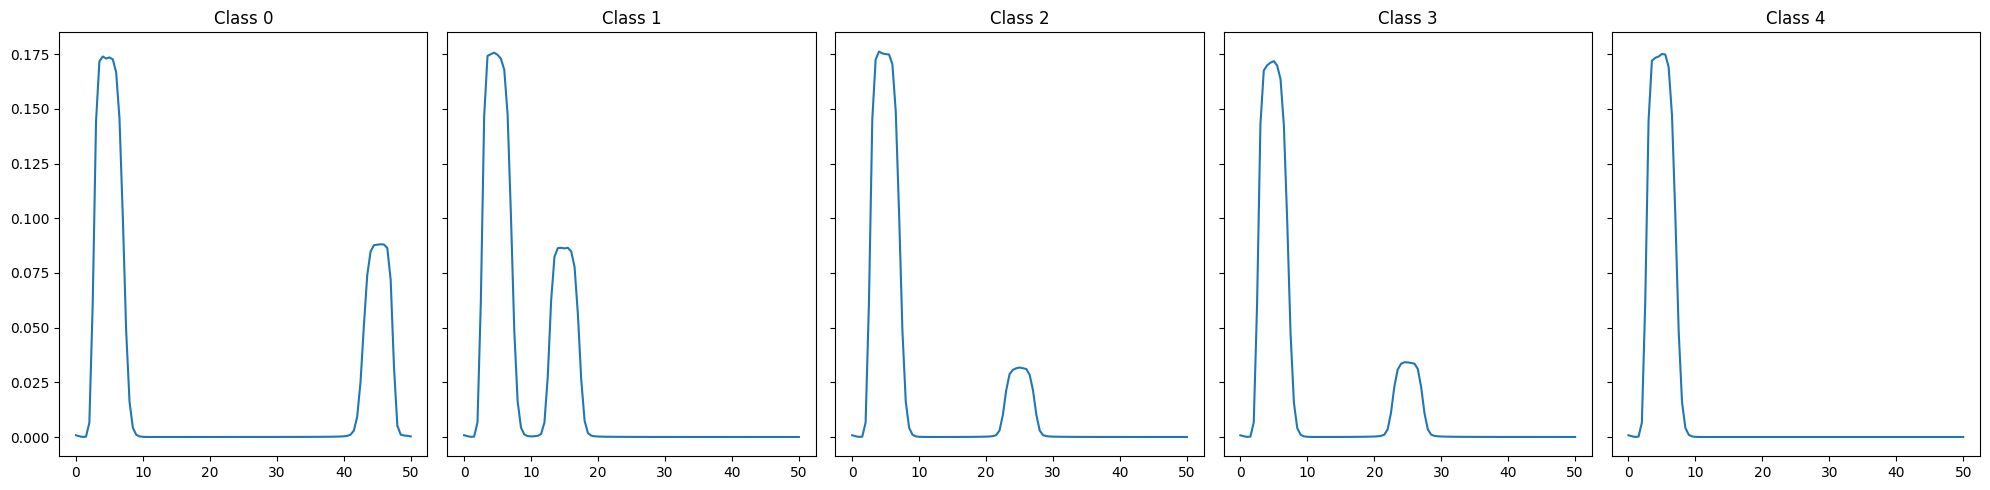

In [7]:
# data generation
from scipy import signal
fs = 100

class_powers = dataset.mean_power.numpy() 

# get the frequencies
F, _ =  signal.welch(dataset[0][0].numpy(), fs, nperseg = fs * 2)

# plot n_class subplots
fig, axes = plt.subplots( 1, dataset.n_class + 1, figsize = (20, 5), sharex=True, sharey=True)

for i in range(dataset.n_class + 1):
    sns.lineplot(x = F, y = class_powers[i], ax = axes[i])
    axes[i].set_title( f"Class {i}" )

plt.tight_layout()
plt.show()
plt.close()

In [8]:
from torch import nn

model = TimeModule.load_from_checkpoint( "/home/guido/github/physioex-private/papers/icml/synt_model/checkpoint/epoch=19-step=21386-val_acc=0.88.ckpt", model_type = "convnet" ).eval()
model = model.to( "cpu" )

model = nn.Sequential(
    model,
    nn.Softmax( dim = 1 )
)

In [9]:
from src.SpectralGradients import SpectralGradients as SG
from src.IntegratedGradients import IntegratedGradients as IG

import torch

# get the available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128

sg = SG(
    f = model, 
    fs = fs,
    Q = 5,
    nperseg = 100,
    noverlap = 50,
    strategy = "highest"
).to(device)
   
x, mask, y = [], [], []

for i in range( 0, batch_size ):
    x_, mask_, y_ = dataset.__getitem__( i , return_mask=True)
    x.append( x_ )
    y.append( y_ )
    mask.append( mask_ )

x = torch.stack( x )
mask = torch.stack( mask )
y = torch.stack( y )

print( x.shape, mask.shape, y.shape )

attr = sg( x.to(device) ).detach().cpu()

wg_attr = attr.sum( dim = -1 )
wg_attr = torch.einsum( "bclt,bcl -> bclt", attr, wg_attr )
print( attr.shape, wg_attr.shape )

time_attr = attr.sum( dim = -2 )
wg_time_attr = wg_attr.sum( dim = -2 )
print( time_attr.shape, wg_time_attr.shape )

# check if there are NaNs

ig = IG( model ).to(device)

ig_attr = ig( x.to(device) ).detach().cpu()

print( ig_attr.shape )



torch.Size([128, 1000]) torch.Size([128, 1000]) torch.Size([128])


100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


torch.Size([128, 7, 50, 1000]) torch.Size([128, 7, 50, 1000])
torch.Size([128, 7, 1000]) torch.Size([128, 7, 1000])
torch.Size([128, 7, 1000])


In [10]:
class Localization(nn.Module):
    def __init__(self):
        super(Localization, self).__init__()

    def forward(self, x, attr, mask):
        attr = nn.functional.relu(attr)
        Rtot = attr.reshape(attr.shape[0], -1).sum(1)
        
        if any(Rtot == 0):
            raise ValueError("Rtot is zero")
        
        Rin = (attr * mask).reshape(attr.shape[0], -1).sum(1)
        mu = Rin / Rtot

        Stot = attr.shape[1:]
        Stot = torch.tensor(Stot).prod().item()
    
        Sin = mask.reshape(mask.shape[0], -1).sum(1)

        if any(Sin == 0):
            raise ValueError("Sin is zero")
        
        return mu * (Stot / Sin)

class DeLocalization( Localization ):
    def __init__( self ):
        super(DeLocalization, self).__init__()
    
    def forward(self, x, attr, mask):
        return super().forward( x, attr, 1 - mask )    

    
def run_explanation_evaluation( metric, x, y, attr, mask, batch_size):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    localization = metric().to(device)

    tmp_mask, tmp_attr, tmp_x = [], [], []

    for i in range( batch_size ):
        if mask[i].sum() == 0:
            continue

        tmp_attr += [ attr[i, y[i].long() ] ]
        tmp_mask += [ mask[i] ]
        tmp_x += [ x[i] ]

    tmp_attr = torch.stack( tmp_attr ).to(device)
    tmp_x = torch.stack( tmp_x ).to(device)
    tmp_mask = torch.stack( tmp_mask ).to(device)


    l1 = localization( tmp_x,  tmp_attr ,  tmp_mask )

    return l1


In [21]:
from src.trapezoid import trapezoid_rule

class ExpectedGradients(nn.Module):
    def __init__(self, 
        f : callable,
        baselines : torch.Tensor,
        n_points : int = 50,
        ):
        super().__init__()

        self.baselines = baselines.expand(n_points + 1, *baselines.shape)
        self.baselines = self.baselines.reshape( (n_points + 1) * baselines.shape[0], *baselines.shape[1:] )

        indexes = torch.randperm(len( self.baselines ))
        self.baselines = self.baselines[indexes]
        self.baselines = self.baselines.reshape( n_points + 1, *baselines.shape )

        self.n = 0

        def segment_fun( alpha : torch.Tensor, x_1: torch.Tensor, x_2: torch.Tensor):
            self.n += 1    
            batch_size = x_1.shape[0]
            x_2 = self.baselines[self.n % self.n_points][:batch_size].to(x_1.device)

            
            return alpha*x_1 + (1-alpha)*x_2

        self.segment_fun = segment_fun
        
        self.fun = f
        self.n_points = n_points
        
    def forward(self, x ):
        
        return trapezoid_rule( self.fun, x, self.baselines[0], self.segment_fun, self.n_points )
    
baselines = []

for i in range( batch_size, batch_size * 4):
    x_, mask_, y_ = dataset.__getitem__( i , return_mask=True)
    baselines.append( x_ )

eg = ExpectedGradients( model, torch.stack( baselines ) ).to(device)

eg_attr = eg( x.to(device) ).detach().cpu()


In [24]:
print( "Localization")
print( run_explanation_evaluation( Localization, x, y, wg_time_attr, mask, batch_size).mean() )
print( run_explanation_evaluation( Localization, x, y, time_attr, mask, batch_size).mean() )
print( run_explanation_evaluation( Localization, x, y, ig_attr, mask, batch_size).mean() )
print( run_explanation_evaluation( Localization, x, y, eg_attr, mask, batch_size).mean() )
print( "DeLocalization")
print( run_explanation_evaluation( DeLocalization, x, y, wg_time_attr, mask, batch_size).mean() )
print( run_explanation_evaluation( DeLocalization, x, y, time_attr, mask, batch_size).mean() )
print( run_explanation_evaluation( DeLocalization, x, y, ig_attr, mask, batch_size).mean() )
print( run_explanation_evaluation( DeLocalization, x, y, eg_attr, mask, batch_size).mean() )

Localization
tensor(3.7498, device='cuda:0')
tensor(2.1631, device='cuda:0')
tensor(2.1402, device='cuda:0')
tensor(1.6131, device='cuda:0')
DeLocalization
tensor(0.0975, device='cuda:0')
tensor(0.5226, device='cuda:0')
tensor(0.4821, device='cuda:0')
tensor(0.6461, device='cuda:0')
